In [92]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

# MLB

In [2]:
event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)

In [96]:
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")

In [10]:
team = "オリオールズ"
lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))

In [11]:
res = np.array([
    [0, 0],  # good -> good or bad
    [0, 0], # bad -> good or bad
])
for elem in lst:
    if is_improved(*elem[:2]):
        if is_improved(*elem[1:]):
            res[0, 0] += 1
        elif is_deteriorated(*elem[1:]):
            res[0, 1] += 1
    elif is_deteriorated(*elem[:2]):
        if is_improved(*elem[1:]):
            res[1, 0] += 1
        elif is_deteriorated(*elem[1:]):
            res[1, 1] += 1

In [12]:
res

array([[ 786, 2015],
       [1496, 3435]])

In [9]:
res

array([[1016, 2200],
       [1687, 3640]])

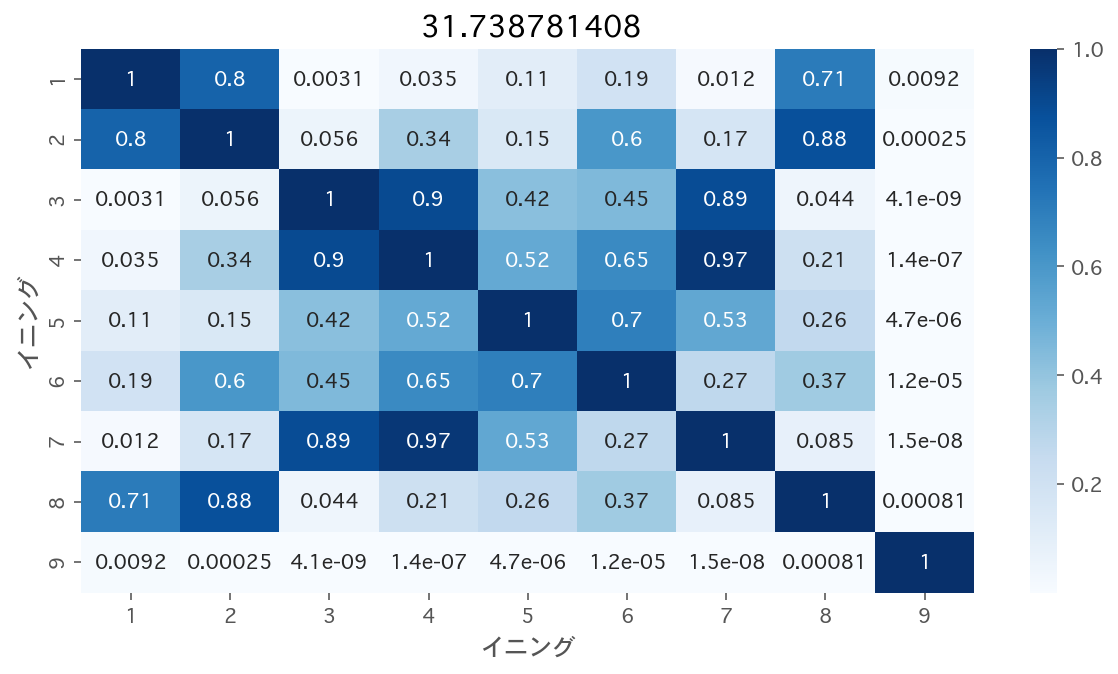

In [15]:
ks_test(event_df[event_df["攻撃チーム"] == "Rソックス"], kind="pvalue")

# KS統計量はそんなによくはない

In [53]:
ad_before = "1000"
dis_before = "0100"
after = "1100"

#mlb_df = pd.DataFrame(columns=teams_mlb, index=["statistic", "pvalue"])
mlb_df = pd.DataFrame(columns=teams_mlb, index=["いい流れ", "悪い流れ", "差", "標準偏差(規格化後)"])

for team in teams_mlb:
    lst1 = extract_case(event_df[event_df.攻撃チーム==team], ad_before, after).状況.values
    lst2 = extract_case(event_df[event_df.攻撃チーム==team], dis_before, after).状況.values
    #mlb_df[team]["statistic"] = stats.ks_2samp(lst1, lst2).statistic
    #mlb_df[team]["pvalue"] = stats.ks_2samp(lst1, lst2).pvalue
    mlb_df[team]["いい流れ"] = entropy(lst1)
    mlb_df[team]["悪い流れ"] = entropy(lst2)
    mlb_df[team]["差"] = mlb_df[team]["いい流れ"] - mlb_df[team]["悪い流れ"]
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    mlb_df[team]["標準偏差(規格化後)"] = std

In [71]:
lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))

In [85]:
form = "0000"
curr = "1000"
df = pd.DataFrame(lst)
lst1 = list(df[(df[0]==form) & (df[1]==curr)][2])
lst2 = list(df[df[1]==curr][2])

In [87]:
stats.ks_2samp(lst1, lst2).statistic

0.013705103969754254

In [109]:
dists = []
stds = []
for team in teams_mlb:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    triple_proba_dict = pd.Series(lst).value_counts() / len(lst)
    df = pd.DataFrame(lst)
    ks_list = []
    for form in set(df[0]):
        for curr in set(df[1]):
            for late in set(df[2]):
                lst1 = list(df[(df[0]==form) & (df[1]==curr)][2])
                lst2 = list(df[df[1]==curr][2])
                try:
                    ks_list.append(np.log(stats.ks_2samp(lst1, lst2).statistic)*triple_proba_dict[(form, curr, late)])
                except:
                    ks_list.append(0)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    dists.append(sum(ks_list))
    stds.append(std)
    print(team)

ブルージェイズ
ジャイアンツ
レンジャーズ
アストロズ
ロッキーズ
パイレーツ
マーリンズ
ロイヤルズ
Wソックス
レッズ
ブリュワーズ
カブス
カージナルス
タイガース
ツインズ
ヤンキース
フィリーズ
アスレチックス
Dバックス
マリナーズ
エンゼルス
レイズ
Rソックス
ナショナルズ
ブレーブス
パドレス
オリオールズ
インディアンス
ドジャース
メッツ


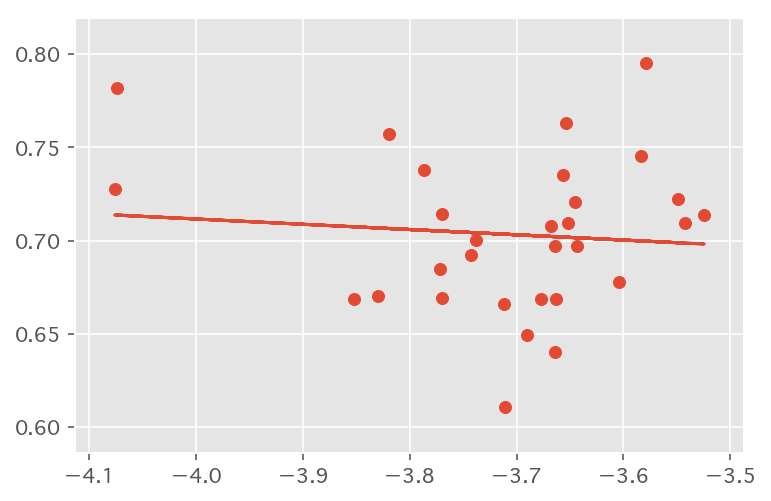

In [110]:
import statsmodels.api as sm

nsample = len(dists)
X = np.column_stack((np.repeat(1, nsample), dists))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(dists, stds)
plt.plot(dists, a+b*np.array(dists))
plt.show()

In [111]:
results.pvalues

array([ 0.01235627,  0.64345416])

In [106]:
diffs = []
stds = []
for team in teams_mlb:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    improved_lst = [elem for elem in lst if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy/first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy/first_cond_entropy, std)

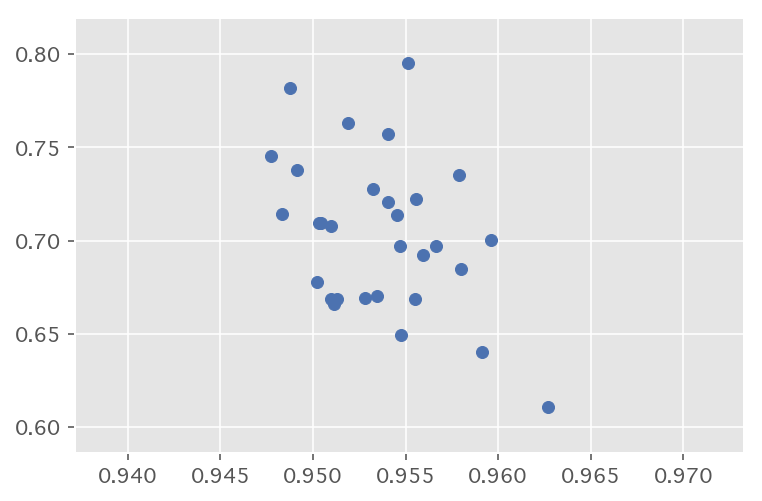

In [68]:
plt.scatter(diffs, stds)

# エントロピーの比を考えるとなんか良さげ

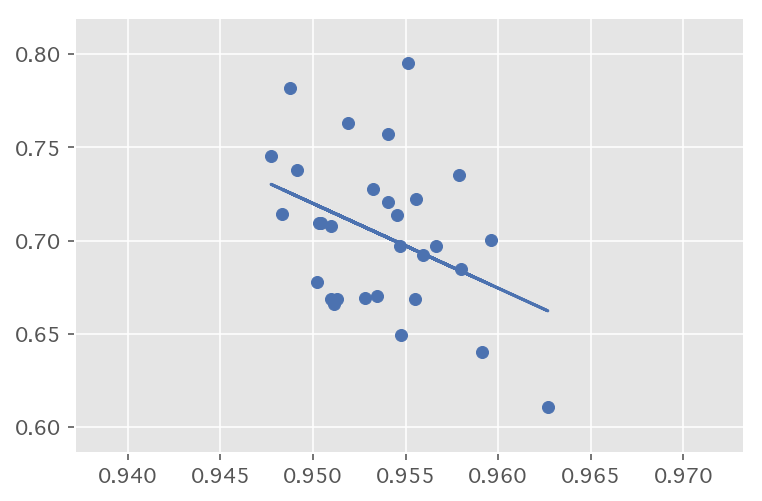

In [69]:
import statsmodels.api as sm

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.show()

In [70]:
results.pvalues

array([ 0.01330393,  0.03083366])

In [112]:
event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")

In [113]:
diffs = []
stds = []
for team in teams_mlb:
    lst_2017 = make_flattened_list(make_inning_triple(make_inning_list(df_2017[df_2017.攻撃チーム==team])))
    lst_2018 = make_flattened_list(make_inning_triple(make_inning_list(df_2018[df_2018.攻撃チーム==team])))
    std_2017 = make_score_df_mlb(team, 2017).describe()[column]["std"] / make_score_df_mlb(team, 2017).describe()[column]["mean"]
    std_2018 = make_score_df_mlb(team, 2018).describe()[column]["std"] / make_score_df_mlb(team, 2018).describe()[column]["mean"]
    second_cond_entropy_2017 = cond_entropy(pd.DataFrame(lst_2017)[2].values, pd.DataFrame(lst_2017)[[0, 1]].values)
    first_cond_entropy_2017 = cond_entropy(pd.DataFrame(lst_2017)[2].values, pd.DataFrame(lst_2017)[[1]].values)
    second_cond_entropy_2018 = cond_entropy(pd.DataFrame(lst_2018)[2].values, pd.DataFrame(lst_2018)[[0, 1]].values)
    first_cond_entropy_2018 = cond_entropy(pd.DataFrame(lst_2018)[2].values, pd.DataFrame(lst_2018)[[1]].values)
    diffs.append(second_cond_entropy_2017/first_cond_entropy_2017)
    stds.append(std_2017)
    diffs.append(second_cond_entropy_2018/first_cond_entropy_2018)
    stds.append(std_2018)
    print(team, diffs[-1], std, first_cond_entropy_2017, second_cond_entropy_2017)

ブルージェイズ 0.8991255552454344 0.735159694044 1.2997211038645253 1.1701461447441943
ジャイアンツ 0.9129475289702915 0.735159694044 1.3088094579802387 1.1767358242093375
レンジャーズ 0.9008774839660436 0.735159694044 1.3533781457960399 1.211466517246921
アストロズ 0.9092300127947884 0.735159694044 1.4066937270263469 1.2712228237328072
ロッキーズ 0.9033710077513075 0.735159694044 1.3746081054614168 1.2350327924979885
パイレーツ 0.9062656567757393 0.735159694044 1.348465347142156 1.2008901904125975
マーリンズ 0.9071847976070426 0.735159694044 1.4065138823013972 1.2492907793851806
ロイヤルズ 0.9069070686975326 0.735159694044 1.2937980695849327 1.164423456539815
Wソックス 0.9047525806104775 0.735159694044 1.3404625110636248 1.2101889356919981
レッズ 0.9083868478759574 0.735159694044 1.3488694257637959 1.2036515855001948
ブリュワーズ 0.9136778897480514 0.735159694044 1.3469253995535526 1.2032687198489733
カブス 0.8992584983170804 0.735159694044 1.3550776059297345 1.2262044922239261
カージナルス 0.9086392286172523 0.735159694044 1.387298724692541 1.22470

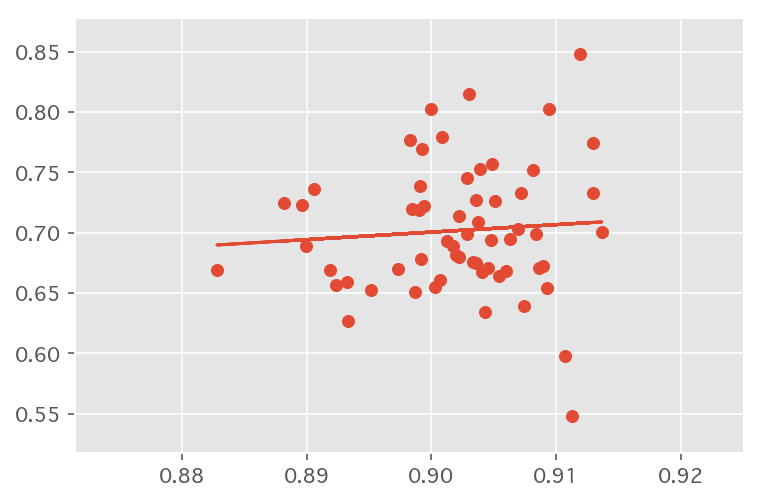

In [114]:
import statsmodels.api as sm

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.show()

In [115]:
results.pvalues

array([ 0.88261932,  0.5620874 ])

# 流れでエントロピーの差を見る

In [14]:
diffs = []
stds = []
for team in teams_mlb:
    print("====="+team+"=====")
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    improved_lst = [elem for elem in lst if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    print("いい流れ : "+str(first_cond_entropy - second_cond_entropy))
    improved_lst = [elem for elem in lst if is_deteriorated(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    print("悪い流れ : "+str(first_cond_entropy - second_cond_entropy))

=====アストロズ=====
いい流れ : 0.07002998302764718
悪い流れ : 0.07987933986297846
=====レンジャーズ=====
いい流れ : 0.08768508268172637
悪い流れ : 0.08333563351314255
=====ブリュワーズ=====
いい流れ : 0.07547572526071189
悪い流れ : 0.07615645418310368
=====ロッキーズ=====
いい流れ : 0.0729843569532238
悪い流れ : 0.08062034474011481
=====マーリンズ=====
いい流れ : 0.08602634396039033
悪い流れ : 0.08640150640831656
=====エンゼルス=====
いい流れ : 0.07161647836365015
悪い流れ : 0.07482160957714767
=====ジャイアンツ=====
いい流れ : 0.08098646435742474
悪い流れ : 0.07552722804968615
=====Dバックス=====
いい流れ : 0.08169983095402245
悪い流れ : 0.0812335414886114
=====ブレーブス=====
いい流れ : 0.08315309778553459
悪い流れ : 0.08645623603320907
=====ロイヤルズ=====
いい流れ : 0.07473927699379646
悪い流れ : 0.07649979845112131
=====ツインズ=====
いい流れ : 0.07334575888129669
悪い流れ : 0.07619868879743175
=====パドレス=====
いい流れ : 0.07762289288740254
悪い流れ : 0.07976712961558752
=====ブルージェイズ=====
いい流れ : 0.07927777352135612
悪い流れ : 0.08395084423806454
=====ドジャース=====
いい流れ : 0.07226038015622471
悪い流れ : 0.07320634125938752
=====Rソックス=====
いい流

In [8]:
# いらない
def calc_kl(triple_list):
    triple_proba_dict = pd.Series(lst).value_counts() / len(lst)
    double_form_proba_dict = pd.Series(np.array(lst)[:, [0, 1]].tolist()).apply(lambda x: tuple(x)).value_counts() / len(lst)
    double_late_proba_dict = pd.Series(np.array(lst)[:, [1, 2]].tolist()).apply(lambda x: tuple(x)).value_counts() / len(lst)
    single_form_proba_dict = pd.Series(np.array(lst)[:, 0]).value_counts() / len(lst)
    single_curr_proba_dict = pd.Series(np.array(lst)[:, 1]).value_counts() / len(lst)
    single_late_proba_dict = pd.Series(np.array(lst)[:, 2]).value_counts() / len(lst)
    
    EPSILON = 1e-12
    triple_array = np.array(triple_list)
    forms = triple_array[:, 0]
    currs = triple_array[:, 1]
    lates = triple_array[:, 2]
    
    res = 0
    for form in set(forms):
        for curr in set(currs):
            for late in set(lates):
                try:
                    second_joint = triple_proba_dict[(form, curr, late)]
                except:
                    second_joint = 0
                try:
                    second_cond = double_form_proba_dict[(form, curr)]
                except:
                    second_cond = 0
                try:
                    first_joint = double_late_proba_dict[(curr, late)]
                except:
                    first_joint = 0
                try:
                    first_cond = single_curr_proba_dict[curr]
                except:
                    first_cond = 0
                second_cond_proba = second_joint / (second_cond+EPSILON)
                first_cond_proba = first_joint / (first_cond+EPSILON)
                try:
                    proba = triple_proba_dict[(form, curr, late)]
                except:
                    proba = 0
                res += proba * (np.log(second_cond_proba+EPSILON) - np.log(first_cond_proba+EPSILON))
    return res   

In [12]:
diffs = []
stds = []
for team in teams_mlb:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    kl = calc_kl(lst)
    #improved_lst = [elem for elem in lst if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    #second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    #first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] #/ make_score_df_mlb(team).describe()[column]["mean"]
    #diffs.append(second_cond_entropy - first_cond_entropy)
    diffs.append(kl)
    stds.append(std)
    #print(team, second_cond_entropy - first_cond_entropy, std)
    print(team, kl, std)

アストロズ 0.0921827942717 3.55344778094
タイガース 0.091673128115 2.9834427068
ナショナルズ 0.0917399152231 3.81223055462
ツインズ 0.0891030494835 3.07989184525
ヤンキース 0.0821399763125 3.22455640701
カージナルス 0.0999102356287 3.15058740153
カブス 0.0952070200779 3.6778387529
アスレチックス 0.084406261628 3.12828629048
ブリュワーズ 0.0924003728762 3.04241493042
オリオールズ 0.0853971064755 3.27605697309
パイレーツ 0.0985586293938 3.02740969913
マリナーズ 0.0926424883208 2.88766551035
Rソックス 0.0980090223918 3.48076121468
ジャイアンツ 0.0893573535296 2.79988836641
レンジャーズ 0.0997752754489 3.39958146692
Dバックス 0.100841553781 3.29510464849
パドレス 0.09430284273 2.48462970909
エンゼルス 0.0940541328363 2.98378361973
レイズ 0.0957469421502 3.04257075472
ロッキーズ 0.0937644815523 3.43481679953
ブルージェイズ 0.0948884409049 2.81830446074
レッズ 0.0949594695286 3.09211382119
メッツ 0.0854285830132 3.11173048679
ブレーブス 0.101631288294 3.23023153989
フィリーズ 0.0873420908939 3.06910023365
インディアンス 0.0942219769818 3.55914302395
マーリンズ 0.101652426175 3.17303251926
ドジャース 0.0893781896773 3.39764754784

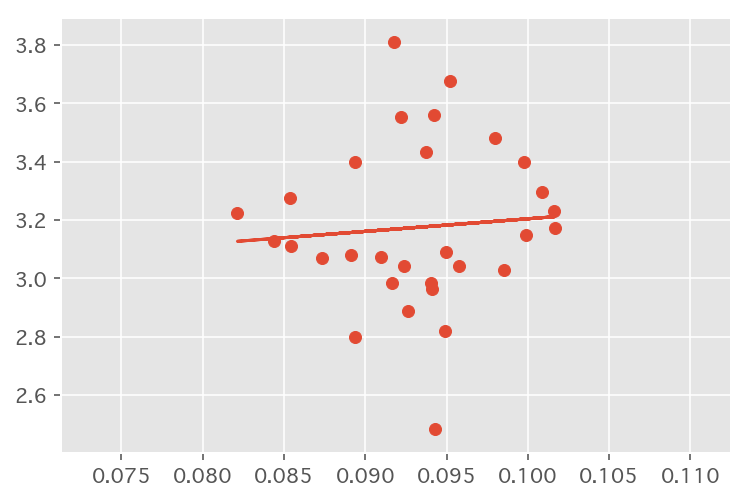

In [13]:
import statsmodels.api as sm

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.show()

In [14]:
results.pvalues

array([ 0.00715023,  0.67596448])